<a href="https://colab.research.google.com/github/Christbm88/MCC_VArtificial_TF/blob/main/Proyecto_final_Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Universidad Nacional de San Agustín**
## **Maestría en Ciencias de la computación**
## ***Reconocimiento de cortes Conformes y No conformes***
### - *Christian Néstor Barriga Marcapura*
### - *Weimar Ccapatinta Huamani*


# IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
# Necesitarás montar tu disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, consulta esto: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Especificar el directorio del conjunto de entrenamiento
XRay_Directory = "/content/drive/MyDrive/data/Entrenamiento"

In [ ]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['Conforme', 'Noconforme']

In [ ]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [ ]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "training")

Found 137 images belonging to 2 classes.


In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "validation")

Found 33 images belonging to 2 classes.


In [ ]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(33, 256, 256, 3)

In [ ]:
train_labels.shape

(33, 2)

In [ ]:
train_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
# Traducción de cada Etiqueta
label_names = {0: 'CONFORME', 1: 'NOCONFORME'}

# VISUALIZACIÓN DEL DATASET

IndexError: ignored

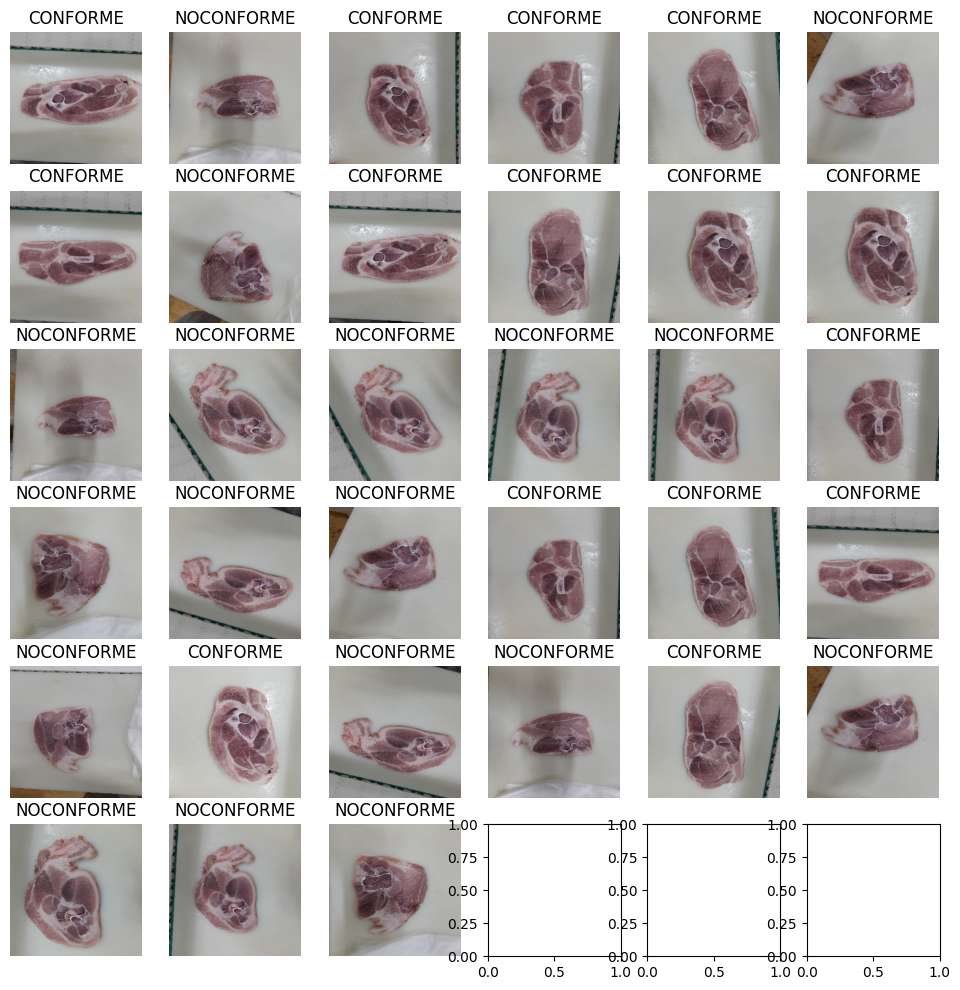

In [ ]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS

In [ ]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Congelar el modelo hasta las últimas etapas - 4 y llevar a cabo un re entrenamiento -5 
for layer in basemodel.layers[:-10]:
    layer.trainable = False

# CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=1e-6)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics = ["accuracy"])

In [ ]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 137 images belonging to 2 classes.
Found 33 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25, 
                              validation_data = val_generator, validation_steps = val_generator.n // 4,
                              callbacks = [checkpointer, earlystopping])

<ipython-input-66-bb26cc4ce111>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25,


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.5038
Epoch 1: val_loss improved from inf to 0.68759, saving model to weights.hdf5
34/34 [==============================] - 53s 1s/step - loss: 0.8201 - accuracy: 0.5038 - val_loss: 0.6876 - val_accuracy: 0.5625
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.7651 - accuracy: 0.5338
Epoch 2: val_loss did not improve from 0.68759
34/34 [==============================] - 34s 1s/step - loss: 0.7651 - accuracy: 0.5338 - val_loss: 0.7223 - val_accuracy: 0.4688
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.5789
Epoch 3: val_loss did not improve from 0.68759
34/34 [==============================] - 34s 1s/step - loss: 0.7017 - accuracy: 0.5789 - val_loss: 0.7040 - val_accuracy: 0.4062
Epoch 4/25
34/34 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.5639
Epoch 4: val_loss did not improve from 0.68759
34/34 [============

# EVALUAR EL MODELO DE DEEP LEARNING ENTRENADO

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

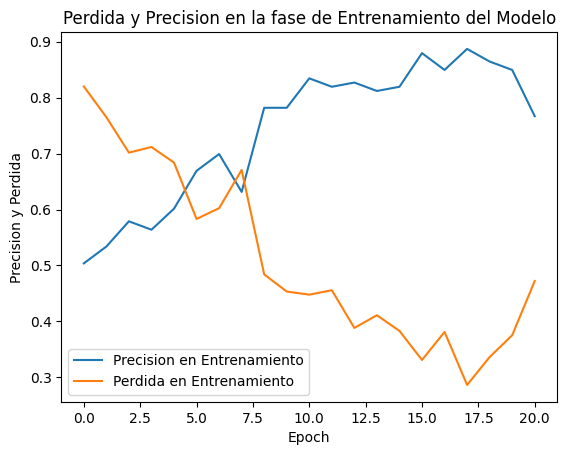

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

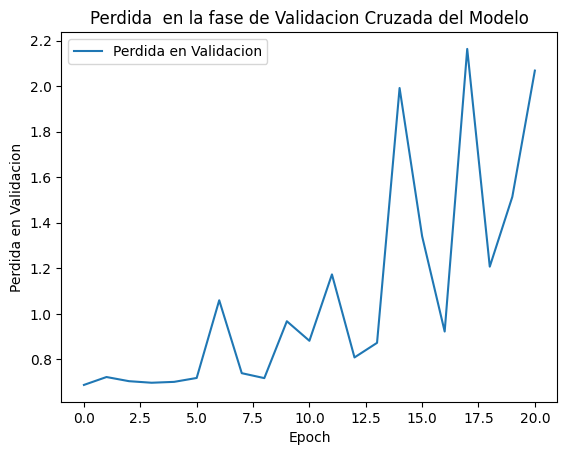

In [ ]:
plt.plot(history.history['val_loss'])

plt.title("Perdida  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Perdida en Validacion")
plt.legend(["Perdida en Validacion"])

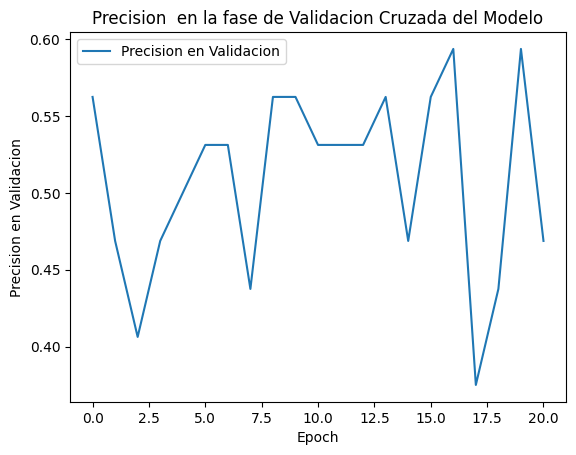

In [ ]:
plt.plot(history.history['val_accuracy'])

plt.title("Precision  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision en Validacion")
plt.legend(["Precision en Validacion"])

In [ ]:
test_directory = "/content/drive/MyDrive/data/test"

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode="categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print("Precision en la fase de Test : {}".format(evaluate[1]))

Found 32 images belonging to 2 classes.


<ipython-input-72-9da2758a8081>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)


1/8 [==>...........................] - ETA: 53s - loss: 1.3799 - accuracy: 0.4688

8/8 [==============================] - 8s 10ms/step - loss: 1.3799 - accuracy: 0.4688
Precision en la fase de Test : 0.46875


In [ ]:
label_names = {0: 'Conforme', 1: 'Noconforme'}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    #if i=0
    for item in os.listdir(os.path.join(test_directory, label_names[i])):
        img = cv2.imread(os.path.join(test_directory, label_names[i], item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 24ms/step


In [ ]:
len(original)

32

In [ ]:
score = accuracy_score(original, prediction)
print("Eficacia de la prediccion {}".format(score))

Eficacia de la prediccion 0.53125


IndexError: ignored

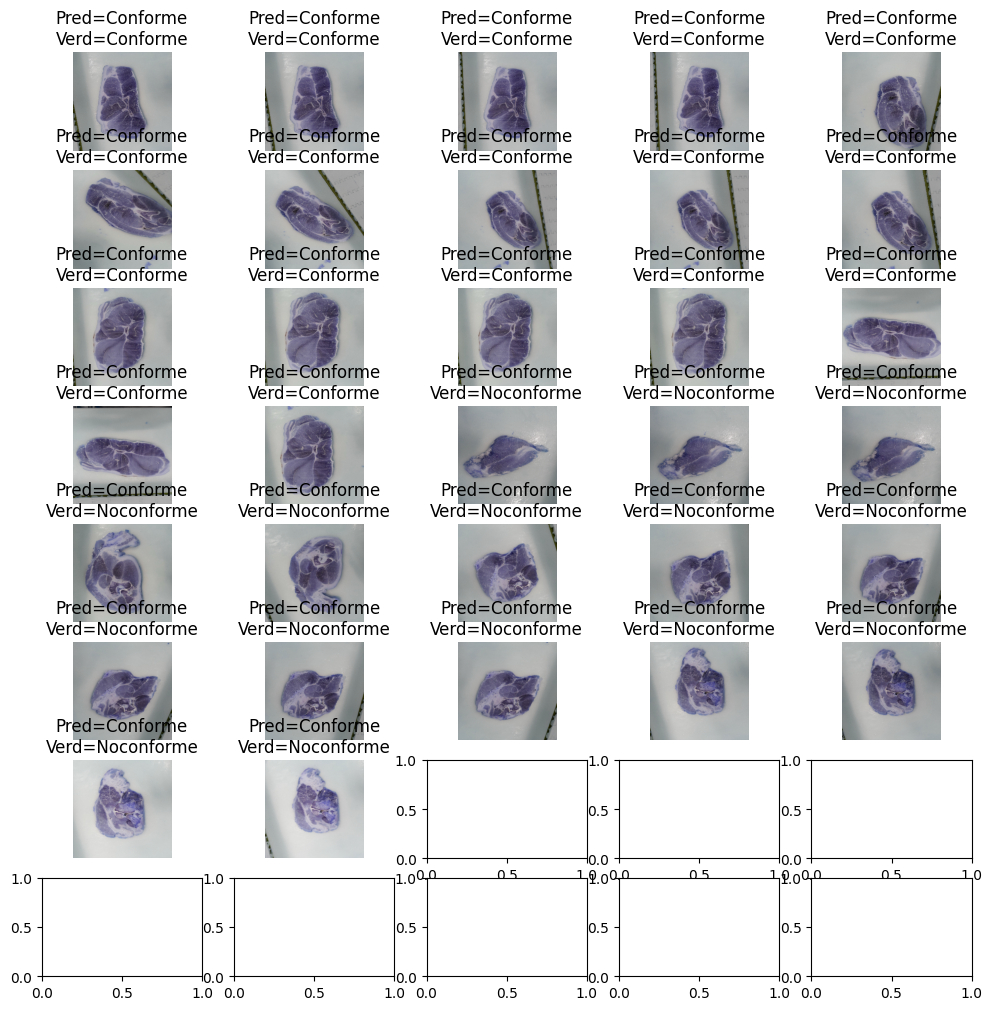

In [ ]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        17
           1       0.00      0.00      0.00        15

    accuracy                           0.53        32
   macro avg       0.27      0.50      0.35        32
weighted avg       0.28      0.53      0.37        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Matriz de Confusion')

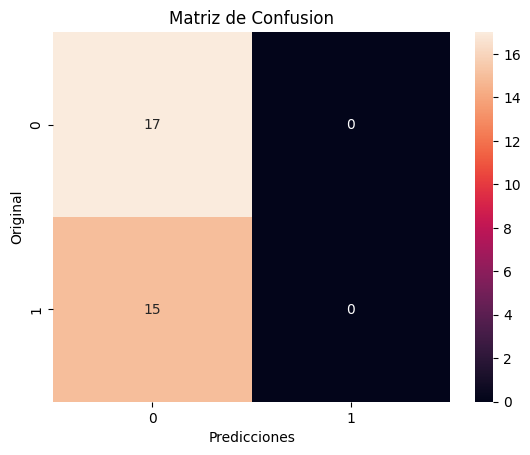

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")